In [20]:
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
scenario = "testing"

In [21]:
sns.set_theme(style="whitegrid")
#path_to_results = os.path.join(os.path.dirname(os.path.dirname(os.getcwd()) ), "amiris_workflow", "2050example")
path_to_results = os.path.join(os.path.dirname(os.path.dirname(os.getcwd()) ), "amiris_workflow" )
path_to_structure = os.path.join(path_to_results, "amiris_data_structure.xlsx")

path_to_h2 = os.path.join(path_to_results, "amiris-config", "data","LS_hydrogen.csv")
#path_to_industrial = os.path.join(path_to_results, "amiris-config", "data","LS_industrial.csv")
path_to_output = os.path.join(path_to_results, "output","amiris_results.csv" )
path_to_storage_levels = os.path.join(path_to_results, "output","final_storage_levels.csv" )
path_to_generation = os.path.join(path_to_results, "output","hourly_generation_per_group.csv" )
path_to_load = os.path.join(path_to_results, "amiris-config", "data","load.csv")
path_to_electricity_prices = os.path.join(path_to_results, "output","raw","EnergyExchangeMulti.csv" )

path_to_plots = os.path.join(os.getcwd(),  "Scenarios", "AMIRIS_Results", scenario )
if not os.path.exists(path_to_plots):
    os.makedirs(path_to_plots)
#-----------------------------------------------------------------------------
elec_prices_data = pd.read_csv(path_to_electricity_prices, sep=";")  
generation_data =  pd.read_csv(path_to_generation, index_col="Unnamed: 0")
load_data = pd.read_csv(path_to_load, sep=";", header=None) 
 
h2_high_data = pd.read_csv(path_to_h2, sep=";", header=None) 
#industrial_data = pd.read_csv(path_to_industrial, sep=";", header=None) 
results_data = pd.read_csv(path_to_output) 
storage_levels_data = pd.read_csv(path_to_storage_levels) 
storages_data = pd.read_excel(path_to_structure, sheet_name='storages', index_col=0)
conventionals_data = pd.read_excel(path_to_structure, sheet_name='conventionals', index_col=0)
renewables_data = pd.read_excel(path_to_structure, sheet_name='renewables', index_col=0)
electrolysers_data = pd.read_excel(path_to_structure, sheet_name='electrolysers', index_col=0)
biogas_data = pd.read_excel(path_to_structure, sheet_name='biogas', index_col=0)
load_shedders_data = pd.read_excel(path_to_structure, sheet_name='load_shedding', index_col=0)

# Why is the electrolysis_hydrogen_generation given in the load generation? I think that value is not needed. 


In [22]:
load_shedders_data

,VOLL,TimeSeries
Type,,
SHEDDING,4000,amiris-config/data/future_load.csv
SHEDDING,1500,amiris-config/data/future_LS_high.csv
SHEDDING,33,amiris-config/data/LS_hydrogen.csv
SHEDDING,250,amiris-config/data/future_LS_low.csv
SHEDDING,500,amiris-config/data/future_LS_mid.csv


In [23]:
fuelprices = pd.read_excel(path_to_structure, sheet_name='scenario_data_emlab', index_col=0)

industrial_heat_price = fuelprices.loc[1,"HYDROGEN"]
fuelprices

,AgentType,CO2,OTHER,HARD_COAL,OIL,HYDROGEN,LIGNITE,NATURAL_GAS,NUCLEAR,WASTE,BIOMASS
0,CarbonMarket,168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FuelsMarket,NaN,45.1,6.73,79.69,48.579253,6.48,14.65,1.69,7.5,35.0


In [24]:
print("Conventionals " + str(conventionals_data["InstalledPowerInMW"].sum()/1000))
print("Renewables " + str(renewables_data["InstalledPowerInMW"].sum()/1000))
print("electrolysers " + str(electrolysers_data["PeakConsumptionInMW"].sum()/1000))
print("biogas " + str(biogas_data["InstalledPowerInMW"].sum()/1000))

Conventionals 18.663943
Renewables 118.252
electrolysers 11.775
biogas 0.0


In [63]:

electrolyser_capacity = h2_high_data[1][0] 
input_hydrogen_demand = h2_high_data[1].sum()
print(input_hydrogen_demand)


359781959.00000006


In [103]:
h2_high_data[1]

0       41070.999886
1       41070.999886
2       41070.999886
3       41070.999886
4       41070.999886
            ...     
8755    41070.999886
8756    41070.999886
8757    41070.999886
8758    41070.999886
8759    41070.999886
Name: 1, Length: 8760, dtype: float64

In [26]:
windon = renewables_data[renewables_data["Set"] =="WindOn"]
print(windon["InstalledPowerInMW"].sum())
windoff = renewables_data[renewables_data["Set"] =="WindOff"]
print(windoff["InstalledPowerInMW"].sum())
PV = renewables_data[renewables_data["Set"] =="OtherPV"]
print(PV["InstalledPowerInMW"].sum())
ROR = renewables_data[renewables_data["Set"] =="RunOfRiver"]
print(ROR["InstalledPowerInMW"].sum())

11200
37001
70051
0


In [27]:
max_output_onshore = 2978 # capacity factor times hours = FLH
max_output_offshore = 4730
max_output_pv = 1059
max_output_ror = 2102
theoretical_max_offshore = max_output_offshore*windoff["InstalledPowerInMW"].sum() # MWH
theoretical_max_onshore = max_output_onshore*windon["InstalledPowerInMW"].sum()
theoretical_max_pv = max_output_pv*PV["InstalledPowerInMW"].sum()
theoretical_max_ror = max_output_ror*ROR["InstalledPowerInMW"].sum()
max_RES = theoretical_max_offshore + theoretical_max_onshore + theoretical_max_pv  + theoretical_max_ror

In [28]:
windon_join = pd.merge(windon, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
print(windon_join["PRODUCTION_IN_MWH"].sum()/1000000)
windoff_join = pd.merge(windoff, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
print(windoff_join["PRODUCTION_IN_MWH"].sum()/1000000)
PV_join = pd.merge(PV, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
print(PV_join["PRODUCTION_IN_MWH"].sum()/1000000)
ROR_join = pd.merge(ROR, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
print(ROR_join["PRODUCTION_IN_MWH"].sum()/1000000)

44.711958996444416
166.9222615423936
102.99787206033001
0.0


In [29]:
conventionals_join = pd.merge(conventionals_data, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
storages_results = pd.merge(storages_data, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
electrolysers_results = pd.merge(electrolysers_data, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')
renewables_results = pd.merge(renewables_data, 
                      results_data, 
                      on ='identifier', 
                      how ='inner')


renewables_results.head()

,identifier,InstalledPowerInMW,OpexVarInEURperMWH,Set,SupportInstrument,FIT,Premium,Lcoe,VARIABLE_COSTS_IN_EURO,REVENUES_IN_EURO,CONSUMPTION_IN_MWH,PRODUCTION_IN_MWH,CONTRIBUTION_MARGIN_IN_EURO
0,20610300117,1000,0.0,OtherPV,NONE,-,-,-,0.000000e+00,3.831879e+07,NaN,1.470327e+06,3.831879e+07
1,20610300118,1000,0.0,OtherPV,NONE,-,-,-,0.000000e+00,3.831879e+07,NaN,1.470327e+06,3.831879e+07
2,20610300119,1000,0.0,OtherPV,NONE,-,-,-,0.000000e+00,3.831879e+07,NaN,1.470327e+06,3.831879e+07
3,20600100116,2000,2.7,WindOff,NONE,-,-,-,2.436097e+07,3.204670e+08,NaN,9.022581e+06,2.961060e+08
4,20600300115,4000,0.0,OtherPV,NONE,-,-,-,0.000000e+00,1.532751e+08,NaN,5.881308e+06,1.532751e+08


,VOLL,TimeSeries
Type,,
SHEDDING,4000,amiris-config/data/future_load.csv
SHEDDING,1500,amiris-config/data/future_LS_high.csv
SHEDDING,33,amiris-config/data/LS_hydrogen.csv
SHEDDING,250,amiris-config/data/future_LS_low.csv
SHEDDING,500,amiris-config/data/future_LS_mid.csv


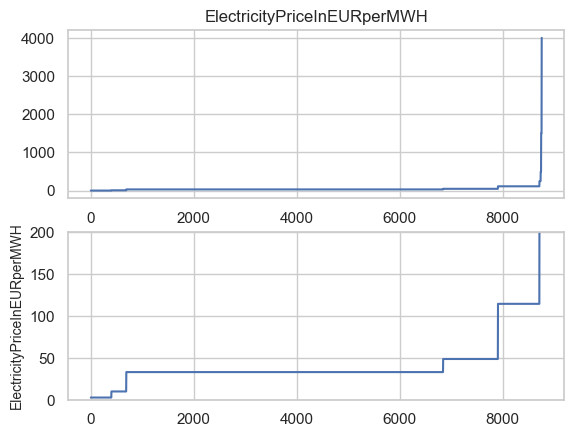

In [30]:
sorted_elec_prices = elec_prices_data["ElectricityPriceInEURperMWH"].copy()
fig, axes= plt.subplots(nrows=2, ncols=1)
sorted_elec_prices.sort_values(ignore_index=True, inplace=True)
axs1 = sorted_elec_prices.plot(ax=axes[0])
plt.ylim([0, 200])
axs2 = sorted_elec_prices.plot(ax=axes[1])
plt.ylabel('ElectricityPriceInEURperMWH', fontsize='small')
axes[0].set_title('ElectricityPriceInEURperMWH')
fig.savefig(path_to_plots + '/' + 'elec_prices.png', bbox_inches='tight', dpi=300)
load_shedders_data

In [31]:
load_generation = pd.concat([generation_data, 
                      load_data],   axis=1 )
load_generation.drop(0, axis=1, inplace=True) # dropping timeseries
load_generation.rename(columns={1: "load" }, inplace=True)
# load_generation.sort_values(by=1, inplace=True) # sorting by increasing load
# load_generation.reset_index(inplace=True )
#load_generation.drop("index", axis=1, inplace=True)
load_generation.drop("electrolysis_hydrogen_generation", axis=1, inplace=True)
load_generation.head()

,res,conventionals,storages_discharging,storages_charging,storages_aggregated_level,load_shedding,electrolysis_power_consumption,load
0,25507.615911,5663.943,0,0,0,40740.428648,11775.0,13481.854990
1,25804.513166,5663.943,0,0,0,40309.519906,11775.0,13308.186265
2,28861.257980,5663.943,0,0,0,36935.821612,11775.0,13013.565427
3,31726.631111,5663.943,0,0,0,34002.709472,11775.0,12825.540560
4,33505.900022,5663.943,0,0,0,32669.192995,11775.0,12987.629233


In [32]:
load_generation["storages_charging"] = load_generation["storages_charging"]*-1
load_generation["electrolysis_power_consumption"] = load_generation["electrolysis_power_consumption"]*-1
load_generation.drop("storages_aggregated_level", axis=1, inplace=True)

In [33]:
RES_use = round((load_generation["res"].sum()/max_RES)*100,2)

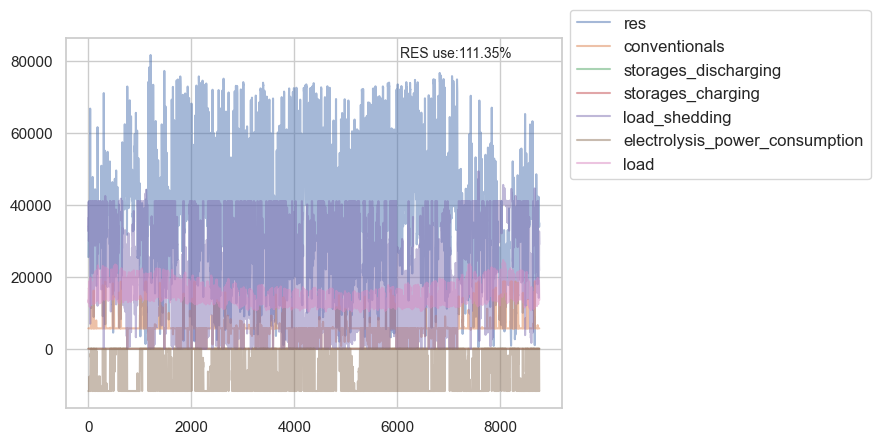

In [34]:
axs1= load_generation.plot(alpha=0.5)
plt.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1, 1.1))
axs1.annotate("RES use:" + str(RES_use ) + "%",
               xy=(0.8, 0.8), xycoords='figure fraction',
               horizontalalignment='right', verticalalignment='bottom',
               fontsize='small')
fig1 = axs1.get_figure()
fig1.savefig(path_to_plots + '/' + 'testing.png', bbox_inches='tight', dpi=300)

,res,conventionals,storages_discharging,storages_charging,load_shedding,electrolysis_power_consumption,load
0,25507.615911,5663.943,0,0,40740.428648,11775.0,13481.854990
1,25804.513166,5663.943,0,0,40309.519906,11775.0,13308.186265
2,28861.257980,5663.943,0,0,36935.821612,11775.0,13013.565427
3,31726.631111,5663.943,0,0,34002.709472,11775.0,12825.540560
4,33505.900022,5663.943,0,0,32669.192995,11775.0,12987.629233


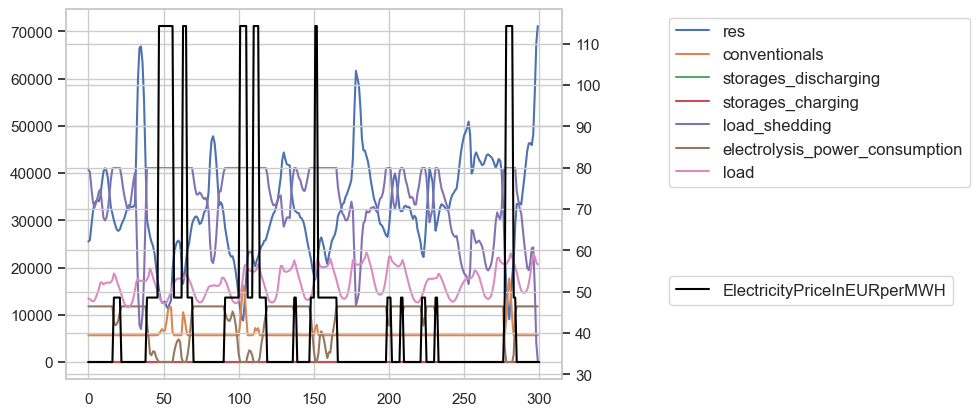

In [35]:
ElectricityPriceInEURperMWH = elec_prices_data["ElectricityPriceInEURperMWH" ]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
load_generation["electrolysis_power_consumption"] = load_generation["electrolysis_power_consumption"]*-1
load_generation.iloc[0:300,0:7].plot( ax=ax1)

ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2,    1))
ax2.plot(ElectricityPriceInEURperMWH.loc[0:300] , color = "black")
#ax2.set_ylim(-1000, 4100)
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.3))
fig1 = ax1.get_figure()
fig1.savefig(path_to_plots + '/' + 'timeseries.png', bbox_inches='tight', dpi=300)

load_generation.head()

In [36]:
marginal_price = {
    0: "PV",
    48.58: "Industrial heat",
    33.00: "Electrolyzer",
    2.70: "Offshore",
    1.35: "Onshore",
    9.93: "Nuclear",
    4000: "VOLL",
    1500: "HighLS",
    500: "MedLS",
    250: "LowLS",
    114.25: "H2 turbine"
}

fuel_colors = {
    'Industrial heat': "black",
    'H2 turbine': "darkred",
    "PV": "gold",
    'Nuclear': "mediumorchid",
    'Offshore': "navy",
    'Onshore': "blue",
    'notfound': "purple",
    'Electrolyzer': "gray",
    "LowLS": "lemonchiffon",
    'HighLS': "darkorange",
    'MedLS': "orange",
    "VOLL": "lime",
}

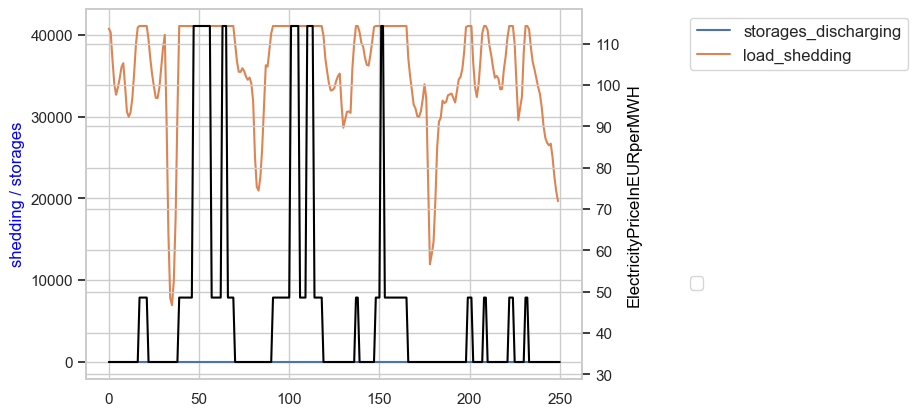

In [37]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
load_generation.iloc[0:250,[2,4]].plot( ax=ax1)
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2,    1))
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.3))
ax2.plot(ElectricityPriceInEURperMWH.loc[0:250] , color = "black")
ax1.set_ylabel('shedding / storages',  color = "blue")
ax2.set_ylabel('ElectricityPriceInEURperMWH', color = "black")
fig.savefig(path_to_plots + '/' + 'storages_loadshedding.png', bbox_inches='tight', dpi=300)

In [38]:
# plt.stackplot( load_generation.index, load_generation.res, load_generation.conventionals, load_generation.load_shedding, load_generation.storages_discharging,
#               load_generation.storages_discharging,  labels=['RES', 'conventional', "load shedding", "dish", "charg"]  )


In [39]:
storages = None
if storages != None:
    path_to_storages_raw = os.path.join(path_to_results, "output","raw","StorageTrader.csv")
    storages_raw = pd.read_csv(path_to_storages_raw, sep=";") 
    storages_results["InstalledPowerInMW"].sum()
    #storage_levels_data["value"][1:].plot.scatter() # 
    storage_levels_data.reset_index().plot.scatter(x = 'index', y = 'value')
    production = storages_results['PRODUCTION_IN_MWH'].sum()
    discharging = generation_data["storages_discharging"].sum()
    charging = generation_data["storages_charging"].sum()

    print("storages GW: " + str(storages_data["InstalledPowerInMW"].sum()/1000))
    
    total_battery_use = load_generation["storages_discharging"].sum()
    print("batteries use GWh: " + str(total_battery_use/1000))
    
    batteries_FLH = (total_battery_use/storages_data["InstalledPowerInMW"].sum())
    print("batteries_FLH: " + str(batteries_FLH)) 
    print("production/discharging "+ str(production/discharging) )
    discharging/charging

In [40]:
#this only work when there is one battery!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# storages_bids_discharge = storages_raw["OfferedDischargePriceInEURperMWH"].dropna()
# storages_bids_discharge.reset_index(drop=True, inplace = True)
# storages_bids_charge = storages_raw["OfferedChargePriceInEURperMWH"].dropna()
# storages_bids_charge.reset_index(drop=True, inplace = True)
# storages_bids_charge.sort_values(ignore_index=True).plot()

# AwardedDischargePowerInMWH = storages_raw["AwardedDischargePowerInMWH"].dropna()
# AwardedDischargePowerInMWH.reset_index(drop=True, inplace = True)
# plt.scatter(x = ElectricityPriceInEURperMWH , y= AwardedDischargePowerInMWH )
# plt.legend()
# plt.xlabel("ElectricityPriceInEURperMWH")
# plt.ylabel("AwardedDischargePowerInMWH")
# plt.savefig(path_to_plots + '/' + 'DischargePowervsprices.png', bbox_inches='tight', dpi=300)
# plt.show()
# plt.close()
# x = storages_bids_discharge.values.reshape(-1,1)
# y = storages_bids_charge.values.reshape(-1,1)
# regr = LinearRegression()
# regr.fit(x, y)
# fig = plt.scatter(x, y,  color='black')
# plt.plot(x, regr.predict(x), color='blue', linewidth=3)
# plt.xlabel("ElectricityPriceInEURperMWH")
# plt.ylabel("OfferedDischargePriceInEURperMWH")
# plt.legend()
# plt.show()
# print("Coefficients: \n", regr.coef_)
# fig, ax1 = plt.subplots()
# storages_bids_discharge.loc[8500:8760].plot(color = "blue")
# ElectricityPriceInEURperMWH.loc[8500:8760].plot( color = "black")
# ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 1))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0

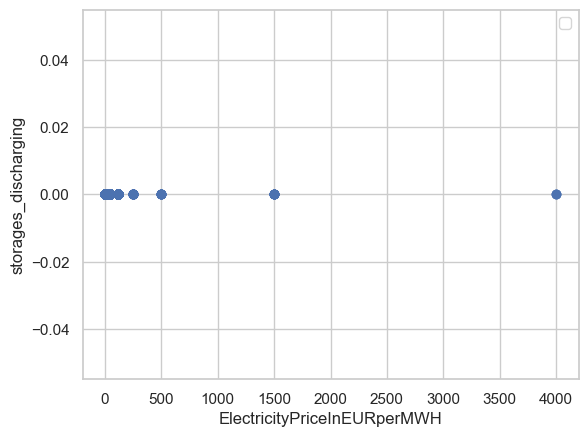

In [41]:
plt.scatter(x = ElectricityPriceInEURperMWH , y= load_generation["storages_discharging"] )
plt.legend()
plt.xlabel("ElectricityPriceInEURperMWH")
plt.ylabel("storages_discharging")
plt.savefig(path_to_plots + '/' + 'BatteriesProductionvsPricesTimeseries.png', bbox_inches='tight', dpi=300)
load_generation["storages_discharging"].sum()

storages_charging       0.0
storages_discharging    0.0


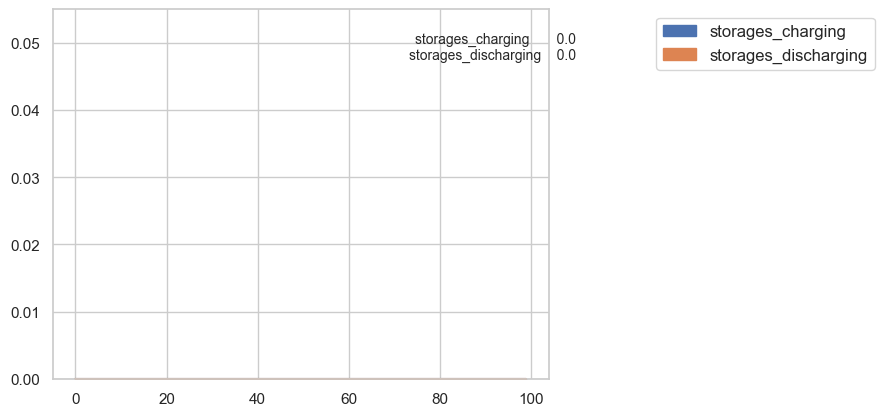

In [42]:
storages = load_generation[["storages_charging", "storages_discharging"]].copy()
sum_storages = storages.sum().divide(1000).to_string()
print(sum_storages)
ax1 = storages.iloc[0:100,:].plot.area()
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 1))
ax1.annotate(sum_storages,
               xy=(0.9, 0.8), xycoords='figure fraction',
               horizontalalignment='right', verticalalignment='top',
               fontsize='small')
fig1 = ax1.get_figure()
fig1.savefig(path_to_plots + '/' + 'storages_timeseries.png', bbox_inches='tight', dpi=300)

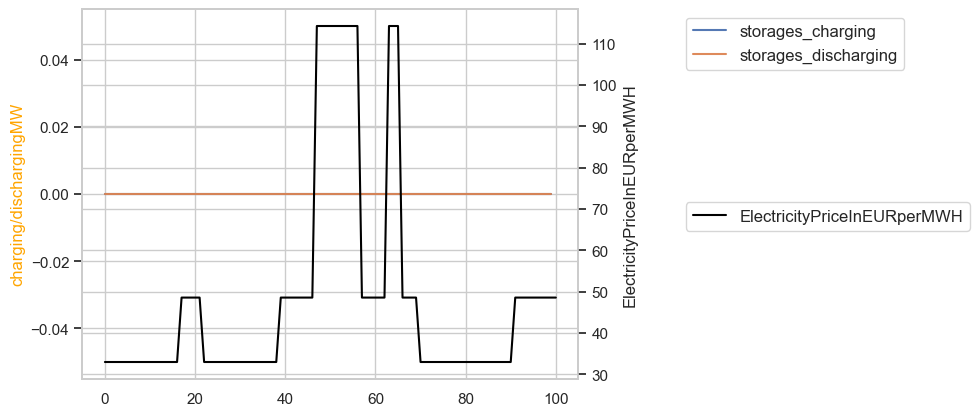

In [43]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
storages.iloc[0:100,:].plot( ax=ax1, alpha=0.95)
#load_generation.iloc[8000:8120,4].plot( ax=ax1, alpha=0.95)
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 1))
ax2.plot(ElectricityPriceInEURperMWH.loc[0:100] , color = "black")
ax1.set_ylabel('charging/dischargingMW',  color = "orange")
ax2.set_ylabel('ElectricityPriceInEURperMWH')
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.5))
fig1 = ax1.get_figure()
fig1.savefig(path_to_plots + '/' + 'storages_timeseries_short.png', bbox_inches='tight', dpi=300)

In [44]:
industrialConsumptioninMWh  = load_generation["electrolysis_power_consumption"]

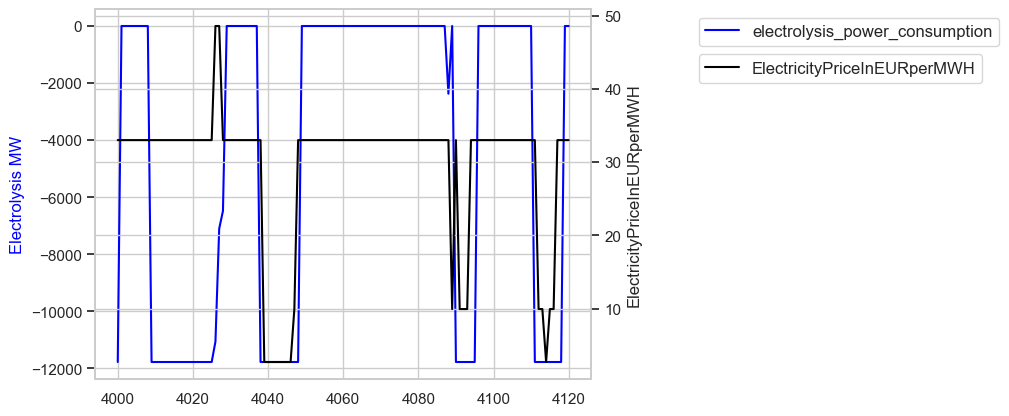

In [45]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
industrialConsumptioninMWh = industrialConsumptioninMWh*-1
industrialConsumptioninMWh.loc[4000:4120].plot( ax=ax1, color = "blue")
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 1))
ax2.plot(ElectricityPriceInEURperMWH.loc[4000:4120] , color = "black")
ax1.set_ylabel('Electrolysis MW', color = "blue")
ax2.set_ylabel('ElectricityPriceInEURperMWH')
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.9))
plt.savefig(path_to_plots + '/' + 'H2vsPricesTimeseries.png', bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>

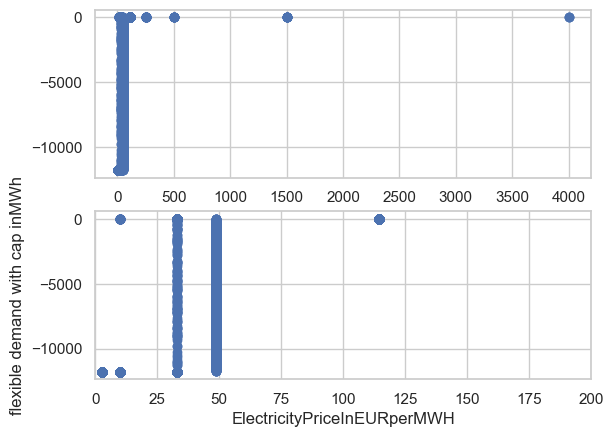

In [46]:
electricityPrice= ElectricityPriceInEURperMWH.values.reshape(-1,1)
industrialPower = industrialConsumptioninMWh.values.reshape(-1,1)
#fig = plt.scatter(electricityPrice, electrolysisPower)
f = plt.figure()  
fig, axes= plt.subplots(nrows=2, ncols=1)
axes[0].scatter(electricityPrice, industrialPower)

axes[1].scatter(electricityPrice, industrialPower)
plt.xlim([0, 200])
plt.xlabel("ElectricityPriceInEURperMWH")
plt.ylabel("flexible demand with cap inMWh")
plt.savefig(path_to_plots + '/' + 'H2vsPrices.png', bbox_inches='tight', dpi=300)

In [47]:
h2prices = pd.DataFrame(list(zip(ElectricityPriceInEURperMWH, industrialConsumptioninMWh)),
              columns =['electricityPrice', 'flexiblePowerCap'])
h2prices.head()


,electricityPrice,flexiblePowerCap
0,33.0,-11775.0
1,33.0,-11775.0
2,33.0,-11775.0
3,33.0,-11775.0
4,33.0,-11775.0


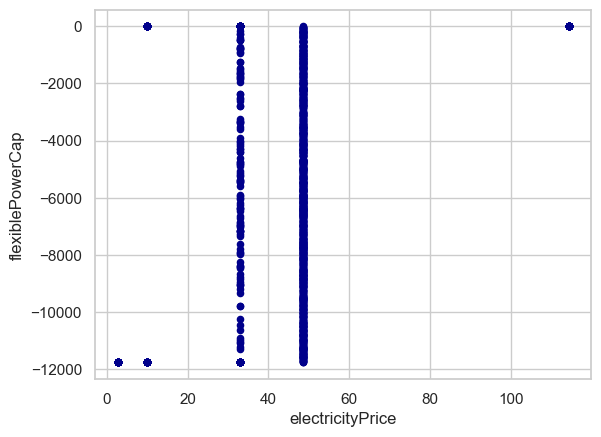

In [48]:
h2prices_filtered = h2prices[h2prices["electricityPrice"] < 200]
ax1 = h2prices_filtered.plot.scatter(x='electricityPrice',
                       y='flexiblePowerCap',
                       c='DarkBlue')
plt.savefig(path_to_plots + '/' + 'flexiblePowerCapvsPricesZoom.png', bbox_inches='tight', dpi=300)
# merged_df.head()


In [49]:
hydrogen_VOLL   = load_shedders_data.loc[load_shedders_data['TimeSeries'] == "amiris-config/data/LS_hydrogen_high.csv", 'VOLL'].sum()
low_VOLL   = load_shedders_data.loc[load_shedders_data['TimeSeries'] == "amiris-config/data/LS_low.csv", 'VOLL'].sum()
mid_VOLL   = load_shedders_data.loc[load_shedders_data['TimeSeries'] == "amiris-config/data/LS_mid.csv", 'VOLL'].sum()
high_VOLL   = load_shedders_data.loc[load_shedders_data['TimeSeries'] == "amiris-config/data/LS_high.csv", 'VOLL'].sum()
load_shedders_data


,VOLL,TimeSeries
Type,,
SHEDDING,4000,amiris-config/data/future_load.csv
SHEDDING,1500,amiris-config/data/future_LS_high.csv
SHEDDING,33,amiris-config/data/LS_hydrogen.csv
SHEDDING,250,amiris-config/data/future_LS_low.csv
SHEDDING,500,amiris-config/data/future_LS_mid.csv


In [50]:
load_and_prices = pd.concat([load_generation["load_shedding"], ElectricityPriceInEURperMWH], ignore_index=True, axis=1)
load_and_prices.columns = ['load_shedding', 'ElectricityPriceInEURperMWH']

In [51]:
load_and_prices

,load_shedding,ElectricityPriceInEURperMWH
0,40740.428648,33.0
1,40309.519906,33.0
2,36935.821612,33.0
3,34002.709472,33.0
4,32669.192995,33.0
...,...,...
8755,21721.454322,33.0
8756,32635.228114,33.0
8757,31430.900561,33.0
8758,30715.600751,33.0


In [52]:
matrix_loads = pd.DataFrame()
hydrogen_load = 41071

#pd.DataFrame( [load_shedders.loc[ "hydrogen","ShedderCapacityMW"]]*8760, index = load_shedder.index)

matrix_loads['load_shedding'] = load_and_prices["load_shedding"]
matrix_loads['ElectricityPriceInEURperMWH'] = ElectricityPriceInEURperMWH
matrix_loads['hydrogen'] = [hydrogen_load]*8760
matrix_loads['LS_low'] = load_and_prices["load_shedding"] -[hydrogen_load]*8760
matrix_loads['LS_mid'] = load_and_prices["load_shedding"] -[hydrogen_load]*8760 -load_data[1]*0.0625  # load is 80% so 5% corresponds to 6.25%
matrix_loads['LS_high'] = load_and_prices["load_shedding"] -[hydrogen_load]*8760 -load_data[1]*0.125 


In [79]:
matrix_loads['hydrogen_shedded'] = matrix_loads.apply(lambda row: row["load_shedding"] if 0 <= row["ElectricityPriceInEURperMWH"]
 <= 33 else row["hydrogen"], axis=1)
matrix_loads.head()

# substracting hydrogen production from load shedding
load_generation["load_shedding"] = load_generation["load_shedding"] - matrix_loads['hydrogen_shedded']


In [105]:
load_generation["hydrogen_produced"] = h2_high_data[1] - matrix_loads['hydrogen_shedded']
load_generation["hydrogen_produced"] 

0         330.571238
1         761.479980
2        4135.178274
3        7068.290414
4        8401.806890
            ...     
8755    19349.545564
8756     8435.771772
8757     9640.099325
8758    10355.399134
8759    12022.344671
Name: hydrogen_produced, Length: 8760, dtype: float64

In [60]:
hydrogen_ENS = sum(matrix_loads['hydrogen_shedded'])
hydrogen_ENS

216434990.32556757

In [55]:
# LOLE
LOLE = len(load_generation[(load_generation["load_shedding"]>0) & (ElectricityPriceInEURperMWH == 4000)])
# this are wrong
# hydrogen_not_produced_mwh = matrix_loads.loc[(matrix_loads["load_shedding"]>0)
#                                                 ,"hydrogen"]
# low_not_produced_mwh = matrix_loads.loc[(matrix_loads["load_shedding"]>0) & (ElectricityPriceInEURperMWH > hydrogen_VOLL) 
#                                                 ,"LS_low"]
# mid_not_produced_mwh = matrix_loads.loc[(matrix_loads["load_shedding"]>0) & (ElectricityPriceInEURperMWH > low_VOLL) 
#                                               ,"LS_mid"]
# high_not_produced_mwh = matrix_loads.loc[(matrix_loads["load_shedding"]>0) & (ElectricityPriceInEURperMWH > mid_VOLL) 
#                                                 ,"LS_high"]

# industrial_ENS = industrial_not_produced_mwh.sum()
# industrial_ENS_gwh = industrial_ENS/1000

0       -2015.803226
1       -2425.003377
2       -5761.874067
3       -8671.483098
4      -10025.260659
            ...     
8755   -21464.687180
8756   -10407.688659
8757   -11510.970335
8758   -12150.668257
8759   -13717.244755
Name: LS_high, Length: 8194, dtype: float64

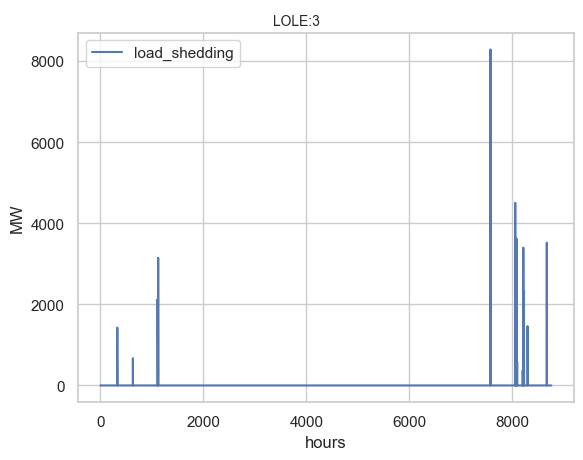

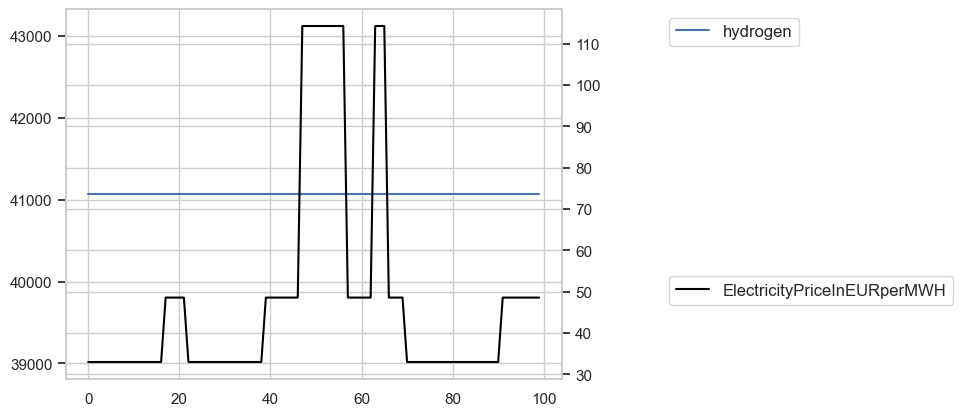

In [82]:
ax1 = load_generation[["load_shedding"]].plot( alpha=0.95)
ax1.annotate("LOLE:" + str(LOLE),
               xy=(0.5, 0.9), xycoords='figure fraction',
               horizontalalignment='right', verticalalignment='bottom',
               fontsize='small')

fig1 = ax1.get_figure()
ax1.set_xlabel("hours")
ax1.set_ylabel("MW")
fig1.savefig(path_to_plots + '/' + 'load_shedding.png', bbox_inches='tight', dpi=300)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
hydrogen_not_produced_mwh.iloc[0:100].plot(ax=ax1)
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1.2,    1))
filtered_elec = ElectricityPriceInEURperMWH.loc[(load_generation["load_shedding"]>0) & (ElectricityPriceInEURperMWH <=hydrogen_VOLL)]

ax2.plot(ElectricityPriceInEURperMWH.iloc[0:100] , color = "black")
ax2.legend(['ElectricityPriceInEURperMWH'],fontsize='medium', loc='upper left', bbox_to_anchor=(1.2, 0.3))
fig1 = ax1.get_figure()
fig1.savefig(path_to_plots + '/' + 'load_shedding_timeseries.png', bbox_inches='tight', dpi=300)

In [57]:
#power consumed in MW
flexconsumer_capped= load_generation["electrolysis_power_consumption"].sum()/1000
totalFlexGWh = round(flexconsumer_capped*electrolysers_results.ConversionFactor[0],0)
print("totalFlexGWh " + str(round(totalFlexGWh,0)))

input_flex_demand_GWh = electrolysers_data.HydrogenProductionTargetInMWH.sum()*12/1000
print("input_H2_demand_GWh " + str(round(input_flex_demand_GWh,0)))

produced_flex_demand = round((totalFlexGWh/input_flex_demand_GWh)*100,2)
print("produced_flex_demand % " +str(produced_flex_demand))

totalFlexGWh 52447.0
input_H2_demand_GWh 51576.0
produced_flex_demand % 101.69


In [62]:
produced_hydrogen  =input_hydrogen_demand - hydrogen_ENS
print("hydrogen produced " + str(produced_hydrogen/1000000))
print("hydrogen_ENS " + str(hydrogen_ENS/1000000))
hydrogen_produced_percent = round((produced_hydrogen /input_hydrogen_demand)*100,2)
print("hydrogen produced/reality " + str(hydrogen_produced_percent))

hydrogen produced 143.34696867443247
hydrogen_ENS 216.43499032556758
hydrogen produced/reality 39.84


In [ ]:
# # Input = TWh monthly12901502.5
# Input = 12901502.5*12/electrolysers_results.ConversionFactor[0]
# hydrogen_monthly = 15505796
# hydrogen_yearly = hydrogen_monthly*12

# hydrogen_and_industrial_gwh = (input_industrial_demand + hydrogen_monthly*12)/1000 # GWh
# produced_industrial = input_industrial_demand - industrial_ENS

# print("hydrogen_and_industrial GWh  " + str(round(hydrogen_and_industrial_gwh,0)))

# print("industrial produced " + str(produced_industrial))

# hydrogen_capacityfactor = round(produced_hydrogen /input_hydrogen_demand*100,0)
# print(hydrogen_capacityfactor)
# industrial_monthly = 53920638 #input (separate demands)
# industrial_demand = 46531661# acccording to output
# industrial_produced_percent = round(produced_industrial /industrial_demand*100,0)
# print("industrial produced/reality " + str(industrial_produced_percent))

# # if industry produced from electrolyzer
# industrial_produced_percent =hydrogen_producedin_percent


In [89]:
load_generation.drop(columns=["storages_charging","storages_discharging"], inplace=True)

KeyError: "['storages_charging', 'storages_discharging'] not found in axis"

In [99]:
load_generation.rename(columns={"res": "Wind and Solar",
                              "conventionals": "Nuclear and H2 turbines",
                              "load_shedding": "Load Shedding", 
                              "electrolysis_power_consumption": "Industrial heat",
                              "load": "Static Load",                                
                             }, inplace=True)

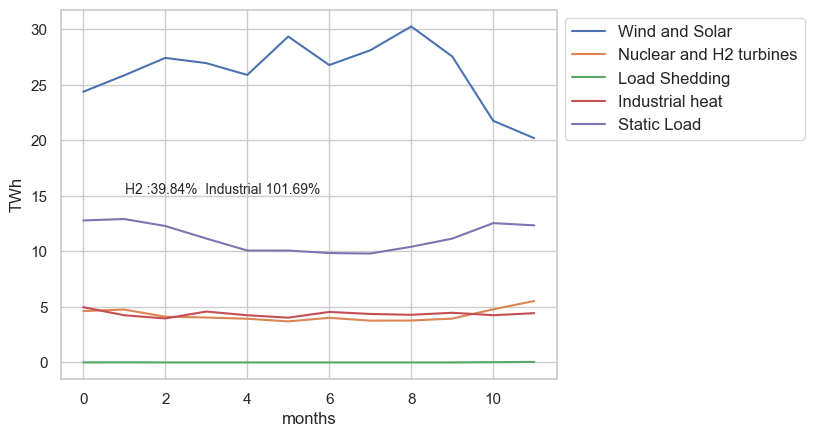

In [100]:
load_generation['group'] = (load_generation.index // 730)
grouped = load_generation.groupby(['group']).sum()
grouped = grouped/1000000
ax1 = grouped.plot()
ax1.annotate("H2 :" + str(hydrogen_produced_percent ) + "%  Industrial " + str(produced_flex_demand) + "%",
               xy=(0.5, 0.5), xycoords='figure fraction',
               horizontalalignment='right', verticalalignment='bottom',
               fontsize='small')
ax1.set_xlabel("months")
ax1.set_ylabel("TWh")
ax1.legend(fontsize='medium', loc='upper left', bbox_to_anchor=(1, 1))
fig1 = ax1.get_figure()
fig1.savefig(path_to_plots + '/' + 'monthly_production.png', bbox_inches='tight', dpi=300)

<AxesSubplot:xlabel='group'>

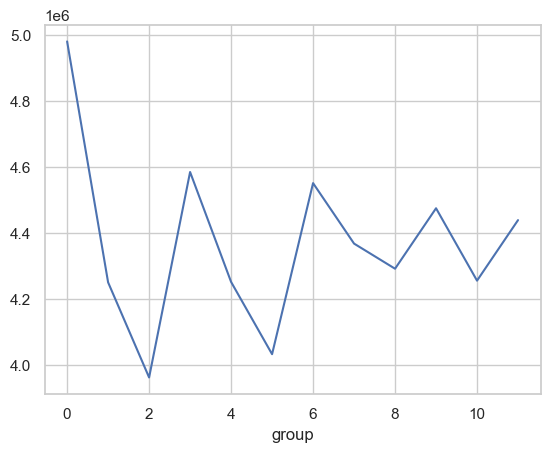

In [66]:
grouped["electrolysis_power_consumption"].plot()

In [67]:
load_generation[["load_shedding"]].sum()

load_shedding    2.165246e+08
dtype: float64